In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import scipy as sp
import scipy.stats as stats
import pandas as pd
from nltk import agreement
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
import statsmodels.api as sm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [45]:
participants = '../resource/docstring-classification-results.csv'
data = pd.read_csv(participants, delimiter=',', index_col=None)
df = data
df.describe()
df.head()


,id,docstring_container_type,docstring_length_category,number_of_lines,start_line,times_assigned,id.1,docstring_id,user_id,classification_id
count,2236.000000,2236.000000,2236.000000,2236.000000,2236.000000,2236.0,2236.000000,2236.000000,2236.000000,2236.000000
mean,388.329159,1.838998,1.936494,6.598390,438.600626,3.0,1552.365385,388.329159,1488.896243,1552.365385
std,214.714932,0.464411,0.892169,4.554387,687.338116,0.0,383.909122,214.714932,363.819882,383.909122
min,1.000000,0.000000,0.000000,1.000000,1.000000,3.0,881.000000,1.000000,871.000000,881.000000
25%,247.000000,2.000000,1.000000,3.000000,104.000000,3.0,1221.750000,247.000000,1130.000000,1221.750000
50%,324.000000,2.000000,2.000000,5.000000,213.000000,3.0,1543.500000,324.000000,1450.000000,1543.500000
75%,560.000000,2.000000,3.000000,10.000000,485.000000,3.0,1874.000000,560.000000,1724.000000,1874.000000
max,836.000000,2.000000,3.000000,20.000000,5921.000000,3.0,2335.000000,836.000000,2311.000000,2335.000000


,id,created,content,docstring_container_type,docstring_length_category,number_of_lines,start_line,times_assigned,url,id.1,created.1,comment,docstring_id,user_id,classification_id,classes
0,2,2019-07-30 11:34:57.511,"""""""Queue redraw of the Agg buffer and request ...",2,0,1,471,3,https://github.com/matplotlib/matplotlib/blob/...,881,2019-07-30 12:26:28.75,NaN,2,871,881,"General Description (""What"")"
1,2,2019-07-30 11:34:57.511,"""""""Queue redraw of the Agg buffer and request ...",2,0,1,471,3,https://github.com/matplotlib/matplotlib/blob/...,881,2019-07-30 12:26:28.75,NaN,2,871,881,"Recap of Algorithmic Details (""Background"")"
2,524,2019-07-30 11:35:00.434,"""""""Return true if the object is a method descr...",2,3,10,79,3,https://github.com/XX-net/XX-Net/blob/master/c...,882,2019-07-30 12:28:07.512,NaN,524,871,882,"General Description (""What"")"
3,524,2019-07-30 11:35:00.434,"""""""Return true if the object is a method descr...",2,3,10,79,3,https://github.com/XX-net/XX-Net/blob/master/c...,882,2019-07-30 12:28:07.512,NaN,524,871,882,Description of Special Cases
4,524,2019-07-30 11:35:00.434,"""""""Return true if the object is a method descr...",2,3,10,79,3,https://github.com/XX-net/XX-Net/blob/master/c...,882,2019-07-30 12:28:07.512,NaN,524,871,882,Return Value


<h3>Analysis of the content classification</h3>


In [46]:
pd.value_counts(df["classes"])


General Description ("What")                       853
Input Parameter(s)                                 346
Return Value                                       339
Example Usage                                      185
Technical Documentation (How")                     172
Structural References                               80
Description of Special Cases                        69
Metadata (author, creation date, version, etc.)     56
Error Cases ("raise")                               46
Recap of Algorithmic Details ("Background")         38
Copyright/Licence                                   21
Other (Please explain in comment)                   20
Upgrade Instructions                                 9
Technical Documentation ("How")                      2
Name: classes, dtype: int64

<h4>How often are the Docstrings Classified?</h4>


In [49]:

times_assigned_df = df[df.times_assigned == 3]
times_assigned_df = times_assigned_df.groupby("docstring_id").agg({"times_assigned": "unique"})
pd.value_counts(times_assigned_df["times_assigned"])






[3]    341
Name: times_assigned, dtype: int64

In [48]:

grouped_by_user = df.groupby(["docstring_id", "user_id", "classes"]).agg({'classes': 'unique'})



grouped_by_docstrings = df.groupby(["docstring_id"], as_index=False).agg({'classification_id': 'count', 'docstring_length_category': 'mean', 'user_id': 'unique', 'classes': 'unique'})




#Get docstrings df with only one time assigned category and with multiple times assigned category:

only_once_chosen = pd.DataFrame(grouped_by_docstrings[grouped_by_docstrings.classification_id < 2])
multiple_times_chosen = pd.DataFrame(grouped_by_docstrings[grouped_by_docstrings.classification_id > 1])

len(only_once_chosen.index)
len(multiple_times_chosen.index)




0

341

<h4>with categories assigned multiple times</h4>


In [53]:
multiple_times_chosen



#Average of categories that a docstring has in the uncleaned data
pd.value_counts(multiple_times_chosen["docstring_id"]).describe()

#Category Distribution in uncleared Data:
pd.value_counts(df["classes"])


#Number of all docstrings:
len(df.groupby("docstring_id"))

#Number of Users that selected a category as the only one:
pd.value_counts(only_once_chosen["user_id"])




#Docstrings that have categories that are at least two times assigned to it:
len(multiple_times_chosen.groupby("docstring_id"))

#Occurrence of categories (When 2 times assigned to docstring):
pd.value_counts(multiple_times_chosen["classes"])
multiple_times_chosen["classes"]



,docstring_id,classification_id,docstring_length_category,user_id,classes
0,1,3,0,"[871, 872, 873]",[Structural References]
1,2,4,0,"[871, 872, 873]","[General Description (""What""), Recap of Algori..."
2,3,5,0,"[874, 1372, 1371]","[Return Value, General Description (""What"")]"
3,4,3,0,"[874, 1372, 1371]","[General Description (""What"")]"
4,5,3,0,"[1214, 1280, 1429]","[General Description (""What"")]"
5,6,6,0,"[878, 1214, 1442]","[Return Value, General Description (""What""), I..."
6,7,3,0,"[1441, 1446, 1449]","[Recap of Algorithmic Details (""Background""), ..."
7,8,4,0,"[1441, 1449]","[Return Value, General Description (""What"")]"
8,9,4,0,"[954, 1309]","[Other (Please explain in comment), Example Us..."
9,10,6,0,"[954, 1309, 1446]","[Return Value, Error Cases (""raise""), General ..."


count    341.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: docstring_id, dtype: float64

General Description ("What")                       853
Input Parameter(s)                                 346
Return Value                                       339
Example Usage                                      185
Technical Documentation (How")                     172
Structural References                               80
Description of Special Cases                        69
Metadata (author, creation date, version, etc.)     56
Error Cases ("raise")                               46
Recap of Algorithmic Details ("Background")         38
Copyright/Licence                                   21
Other (Please explain in comment)                   20
Upgrade Instructions                                 9
Technical Documentation ("How")                      2
Name: classes, dtype: int64

341

Series([], Name: user_id, dtype: int64)

341

[General Description ("What")]                                                                                                                                                                                             34
[Copyright/Licence]                                                                                                                                                                                                         6
[Structural References]                                                                                                                                                                                                     3
[Input Parameter(s)]                                                                                                                                                                                                        2
[General Description ("What"), Input Parameter(s), Structural References]                                       

0                                [Structural References]
1      [General Description ("What"), Recap of Algori...
2           [Return Value, General Description ("What")]
3                         [General Description ("What")]
4                         [General Description ("What")]
5      [Return Value, General Description ("What"), I...
6      [Recap of Algorithmic Details ("Background"), ...
7           [Return Value, General Description ("What")]
8      [Other (Please explain in comment), Example Us...
9      [Return Value, Error Cases ("raise"), General ...
10     [Technical Documentation (How"), General Descr...
11     [General Description ("What"), Technical Docum...
12                        [General Description ("What")]
13     [Upgrade Instructions, General Description ("W...
14     [General Description ("What"), Return Value, I...
15     [General Description ("What"), Structural Refe...
16          [Return Value, General Description ("What")]
17                        [Gene

<h4>Occurrence of categories that are assigned twice to a docstring</h4>


General Description ("What")                       297
Input Parameter(s)                                 113
Return Value                                       107
Example Usage                                       62
Technical Documentation (How")                      43
Structural References                               19
Metadata (author, creation date, version, etc.)     18
Error Cases ("raise")                               16
Description of Special Cases                        13
Copyright/Licence                                    7
Recap of Algorithmic Details ("Background")          6
Upgrade Instructions                                 4
Other (Please explain in comment)                    3
Name: classes, dtype: int64

337

([<matplotlib.axis.YTick at 0x16dea731470>,
 <a list of 13 Text yticklabel objects>)

337

,docstring_id,classes,user_id
42,22,Other (Please explain in comment),2
89,123,Other (Please explain in comment),2
338,269,Other (Please explain in comment),2


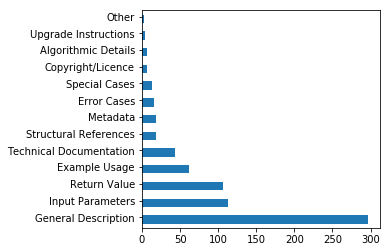

In [54]:
categories_count_df = pd.DataFrame(df, columns=["docstring_id", "user_id", "classes"]).groupby(["docstring_id", "classes"], as_index=False).agg({'user_id': 'count'})
categories_count_df = categories_count_df[categories_count_df.user_id > 1]
pd.value_counts(categories_count_df["classes"])
categories_count_df["docstring_id"].nunique()

pos = np.arange(13)+.13

category_labels = ["General Description", "Input Parameters", "Return Value", "Example Usage", "Technical Documentation", 
                   "Structural References", "Metadata", "Error Cases", "Special Cases",
                   "Copyright/Licence", "Algorithmic Details", "Upgrade Instructions",
                   "Other"]

pd.value_counts(categories_count_df["classes"]).plot.barh()
#plt.tight_layout()
plt.yticks(pos, category_labels)
plt.subplots_adjust(left=0.35)
plt.savefig("category-occurrence.png")
#Amount of docstrings with at least one assigned category:
categories_count_df["docstring_id"].nunique()
categories_count_df[categories_count_df.classes == "Other (Please explain in comment)"]




<h4>Inter-rater agreement and frequent itemset</h4>


In [56]:

docstring_dict = {}

def create_class_list(df):
    class_list = []
    if 'General Description ("What")' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Technical Documentation (How")' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Recap of Algorithmic Details ("Background")' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Description of Special Cases' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Input Parameter(s)' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Return Value' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Error Cases ("raise")' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Example Usage' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Metadata (author, creation date, version, etc.)' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Upgrade Instructions' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Structural References' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Copyright/Licence' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
    if 'Other (Please explain in comment)' in list(df['classes']):
        class_list.append(1)
    else:
        class_list.append(0)
        
    return class_list
    

def get_describe(df_in):
    class_lists = df_in.groupby(["user_id"], as_index=False).apply(create_class_list)
    print(class_lists)
    
    taskdata = []
    
    if len(class_lists) > 1:
        for i in range(len(class_lists)):
            taskdata += [[i,str(j),str(class_lists[i][j])] for j in range(0,len(class_lists[i]))]\
             
        ratingtask = agreement.AnnotationTask(data=taskdata)
        return ratingtask.multi_kappa()
    
    return np.NaN

interrater_df = pd.DataFrame(df, columns=["docstring_id", "user_id", "classes"])
grouped_interrater = interrater_df.groupby(["docstring_id"], as_index=False)



test_df = interrater_df["classes"].groupby([interrater_df["docstring_id"], interrater_df["user_id"]])
category_count_df = interrater_df.groupby(["docstring_id", 'classes'], as_index=False).agg({'user_id': 'count'})
category_count_df = category_count_df[category_count_df.user_id > 1]

class_set = category_count_df.groupby(["docstring_id"], as_index=False).agg({'classes': 'unique'})

len(class_set["classes"])

len(categories_count_df.groupby("docstring_id").nunique())

te = TransactionEncoder()
te_ary = te.fit(class_set["classes"]).transform(class_set["classes"])
class_itemset_df = pd.DataFrame(te_ary, columns=te.columns_)
remaining_categories_itemset = class_itemset_df.copy()
del remaining_categories_itemset['General Description ("What")']
del remaining_categories_itemset['Input Parameter(s)']
del remaining_categories_itemset['Return Value']
del remaining_categories_itemset['Error Cases ("raise")']



apriori(class_itemset_df, min_support=0.1)
class_itemset_df
apriori(remaining_categories_itemset, min_support=0.005)
remaining_categories_itemset
occurrence_of_categories = pd.value_counts(category_count_df["classes"])
occurrence_of_categories

grouped_with_class_list = pd.DataFrame(grouped_interrater.apply(get_describe))

grouped_with_class_list.describe()





337

337

,support,itemsets
0,0.183976,(3)
1,0.881306,(4)
2,0.335312,(5)
3,0.317507,(9)
4,0.127596,(11)
5,0.172107,"(3, 4)"
6,0.302671,"(4, 5)"
7,0.278932,"(9, 4)"
8,0.103858,"(11, 4)"
9,0.163205,"(9, 5)"


,support,itemsets
0,0.020772,(0)
1,0.038576,(1)
2,0.183976,(2)
3,0.053412,(3)
4,0.008902,(4)
5,0.017804,(5)
6,0.056380,(6)
7,0.127596,(7)
8,0.011869,(8)
9,0.008902,"(1, 2)"


0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
dtype: object
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
dtype: object
0    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dtype: object
0    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
1    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
2    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dtype: object
0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dtype: object
0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dtype: object
0    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
1    [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
2    [1, 0, 0, 0

,0
count,340.000000
mean,0.732894
std,0.253474
min,-0.130435
25%,0.597938
50%,0.771930
75%,1.000000
max,1.000000
